In [2]:
import numpy as np
import pandas as pd

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

import plotly.offline as py
color = sns.color_palette()
import plotly.graph_objs as go
py.init_notebook_mode(connected=True)
import plotly.tools as tls

%matplotlib inline

In [4]:
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score 
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
import joblib
from tqdm.notebook import tqdm

# Подготовка данных

In [5]:
df = pd.read_pickle('df_done_sub.pkl') #выборка с уже объединеными подклассами звезд 
df.head()

objID         ra       dec         z      zErr   class  \
0  1237679341106758387  37.470142 -5.554778  0.785255  0.000138  GALAXY   
1  1237679341106757929  37.431501 -5.600435  1.285837  3.473993     QSO   
2  1237679341106758149  37.388988 -5.556329  0.779955  0.000054  GALAXY   
3  1237679440426172681  37.327114 -5.485252  0.714883  0.000028  GALAXY   
4  1237679341106692861  37.315868 -5.519308  0.316563  0.000031  GALAXY   

  subClass  psfMag_u  psfMag_g  psfMag_r  psfMag_i  psfMag_z  cModelMag_u  \
0      NaN  23.38412  23.00183  22.67571  21.95927  21.39581     20.01718   
1      NaN  22.52914  23.78679  23.21358  22.17294  21.80350     21.23949   
2      NaN  25.44541  23.13342  23.57675  24.34838  22.31492     20.38550   
3      NaN  25.43466  23.13782  23.31316  22.53812  22.60905     25.45580   
4      NaN  23.17536  21.34756  20.35171  20.05924  19.64511     21.14052   

   cModelMag_g  cModelMag_r  cModelMag_i  cModelMag_z  
0     21.90474     21.99600     21.05722     20.29795  
1     20.26025     22.12909     21.14929     20.66354  
2     22.09762     23.74675     24.19759     20.62257  
3     22.96513     23.37321     22.59266     22.64923  
4     20.62957     19.60872     19.07587     18.90757

In [6]:
df.shape

(4614588, 17)

In [7]:
df[df['objID'] == 1237648720142401611]

objID         ra       dec         z      zErr   class  \
953961  1237648720142401611  146.71421 -1.041304  0.021222  0.000009  GALAXY   

           subClass  psfMag_u  psfMag_g  psfMag_r  psfMag_i  psfMag_z  \
953961  STARFORMING  19.08621  17.41779  16.59581  16.03497  15.68077   

        cModelMag_u  cModelMag_g  cModelMag_r  cModelMag_i  cModelMag_z  
953961     16.81934     15.38817     14.67877     14.25035     13.97063

In [8]:
df = df.drop_duplicates('objID', keep = 'last')

In [9]:
df[df['objID'] == 1237648720142401611]

objID         ra       dec         z      zErr   class  \
953961  1237648720142401611  146.71421 -1.041304  0.021222  0.000009  GALAXY   

           subClass  psfMag_u  psfMag_g  psfMag_r  psfMag_i  psfMag_z  \
953961  STARFORMING  19.08621  17.41779  16.59581  16.03497  15.68077   

        cModelMag_u  cModelMag_g  cModelMag_r  cModelMag_i  cModelMag_z  
953961     16.81934     15.38817     14.67877     14.25035     13.97063

In [10]:
df['ob'] = 1
df['ob'][df['subClass'] == 'OB'] = 0

<ipython-input-10-f642a49e4a12>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [11]:
df3 = df.copy()
labels = {'STAR':1, 'GALAXY':2, 'QSO':3}
df.replace({'class':labels}, inplace = True)
df.head()

objID         ra       dec         z      zErr  class  \
0  1237679341106758387  37.470142 -5.554778  0.785255  0.000138      2   
1  1237679341106757929  37.431501 -5.600435  1.285837  3.473993      3   
2  1237679341106758149  37.388988 -5.556329  0.779955  0.000054      2   
3  1237679440426172681  37.327114 -5.485252  0.714883  0.000028      2   
4  1237679341106692861  37.315868 -5.519308  0.316563  0.000031      2   

  subClass  psfMag_u  psfMag_g  psfMag_r  psfMag_i  psfMag_z  cModelMag_u  \
0      NaN  23.38412  23.00183  22.67571  21.95927  21.39581     20.01718   
1      NaN  22.52914  23.78679  23.21358  22.17294  21.80350     21.23949   
2      NaN  25.44541  23.13342  23.57675  24.34838  22.31492     20.38550   
3      NaN  25.43466  23.13782  23.31316  22.53812  22.60905     25.45580   
4      NaN  23.17536  21.34756  20.35171  20.05924  19.64511     21.14052   

   cModelMag_g  cModelMag_r  cModelMag_i  cModelMag_z  ob  
0     21.90474     21.99600     21.05722     20.29795   1  
1     20.26025     22.12909     21.14929     20.66354   1  
2     22.09762     23.74675     24.19759     20.62257   1  
3     22.96513     23.37321     22.59266     22.64923   1  
4     20.62957     19.60872     19.07587     18.90757   1

In [12]:
X =  df.drop(['class','subClass', 'objID', 'z', 'zErr', 'ra', 'dec', 'ob'], axis = 1).values
y = df['ob'].values
c = df['class'].values
c

array([2, 3, 2, ..., 3, 2, 2])

Посмотрим разделимость OB от квазаров, других хвезд и галактик 

In [15]:
df0 = pd.concat([df[df['ob']==0].sample(3000),  df[df['class']==2].sample(3000)])#, df[df['class']==3].sample(1000), df[df['ob']==1][df[df['ob']==1]['class']==1].sample(1000)])

Проверим для галактик:

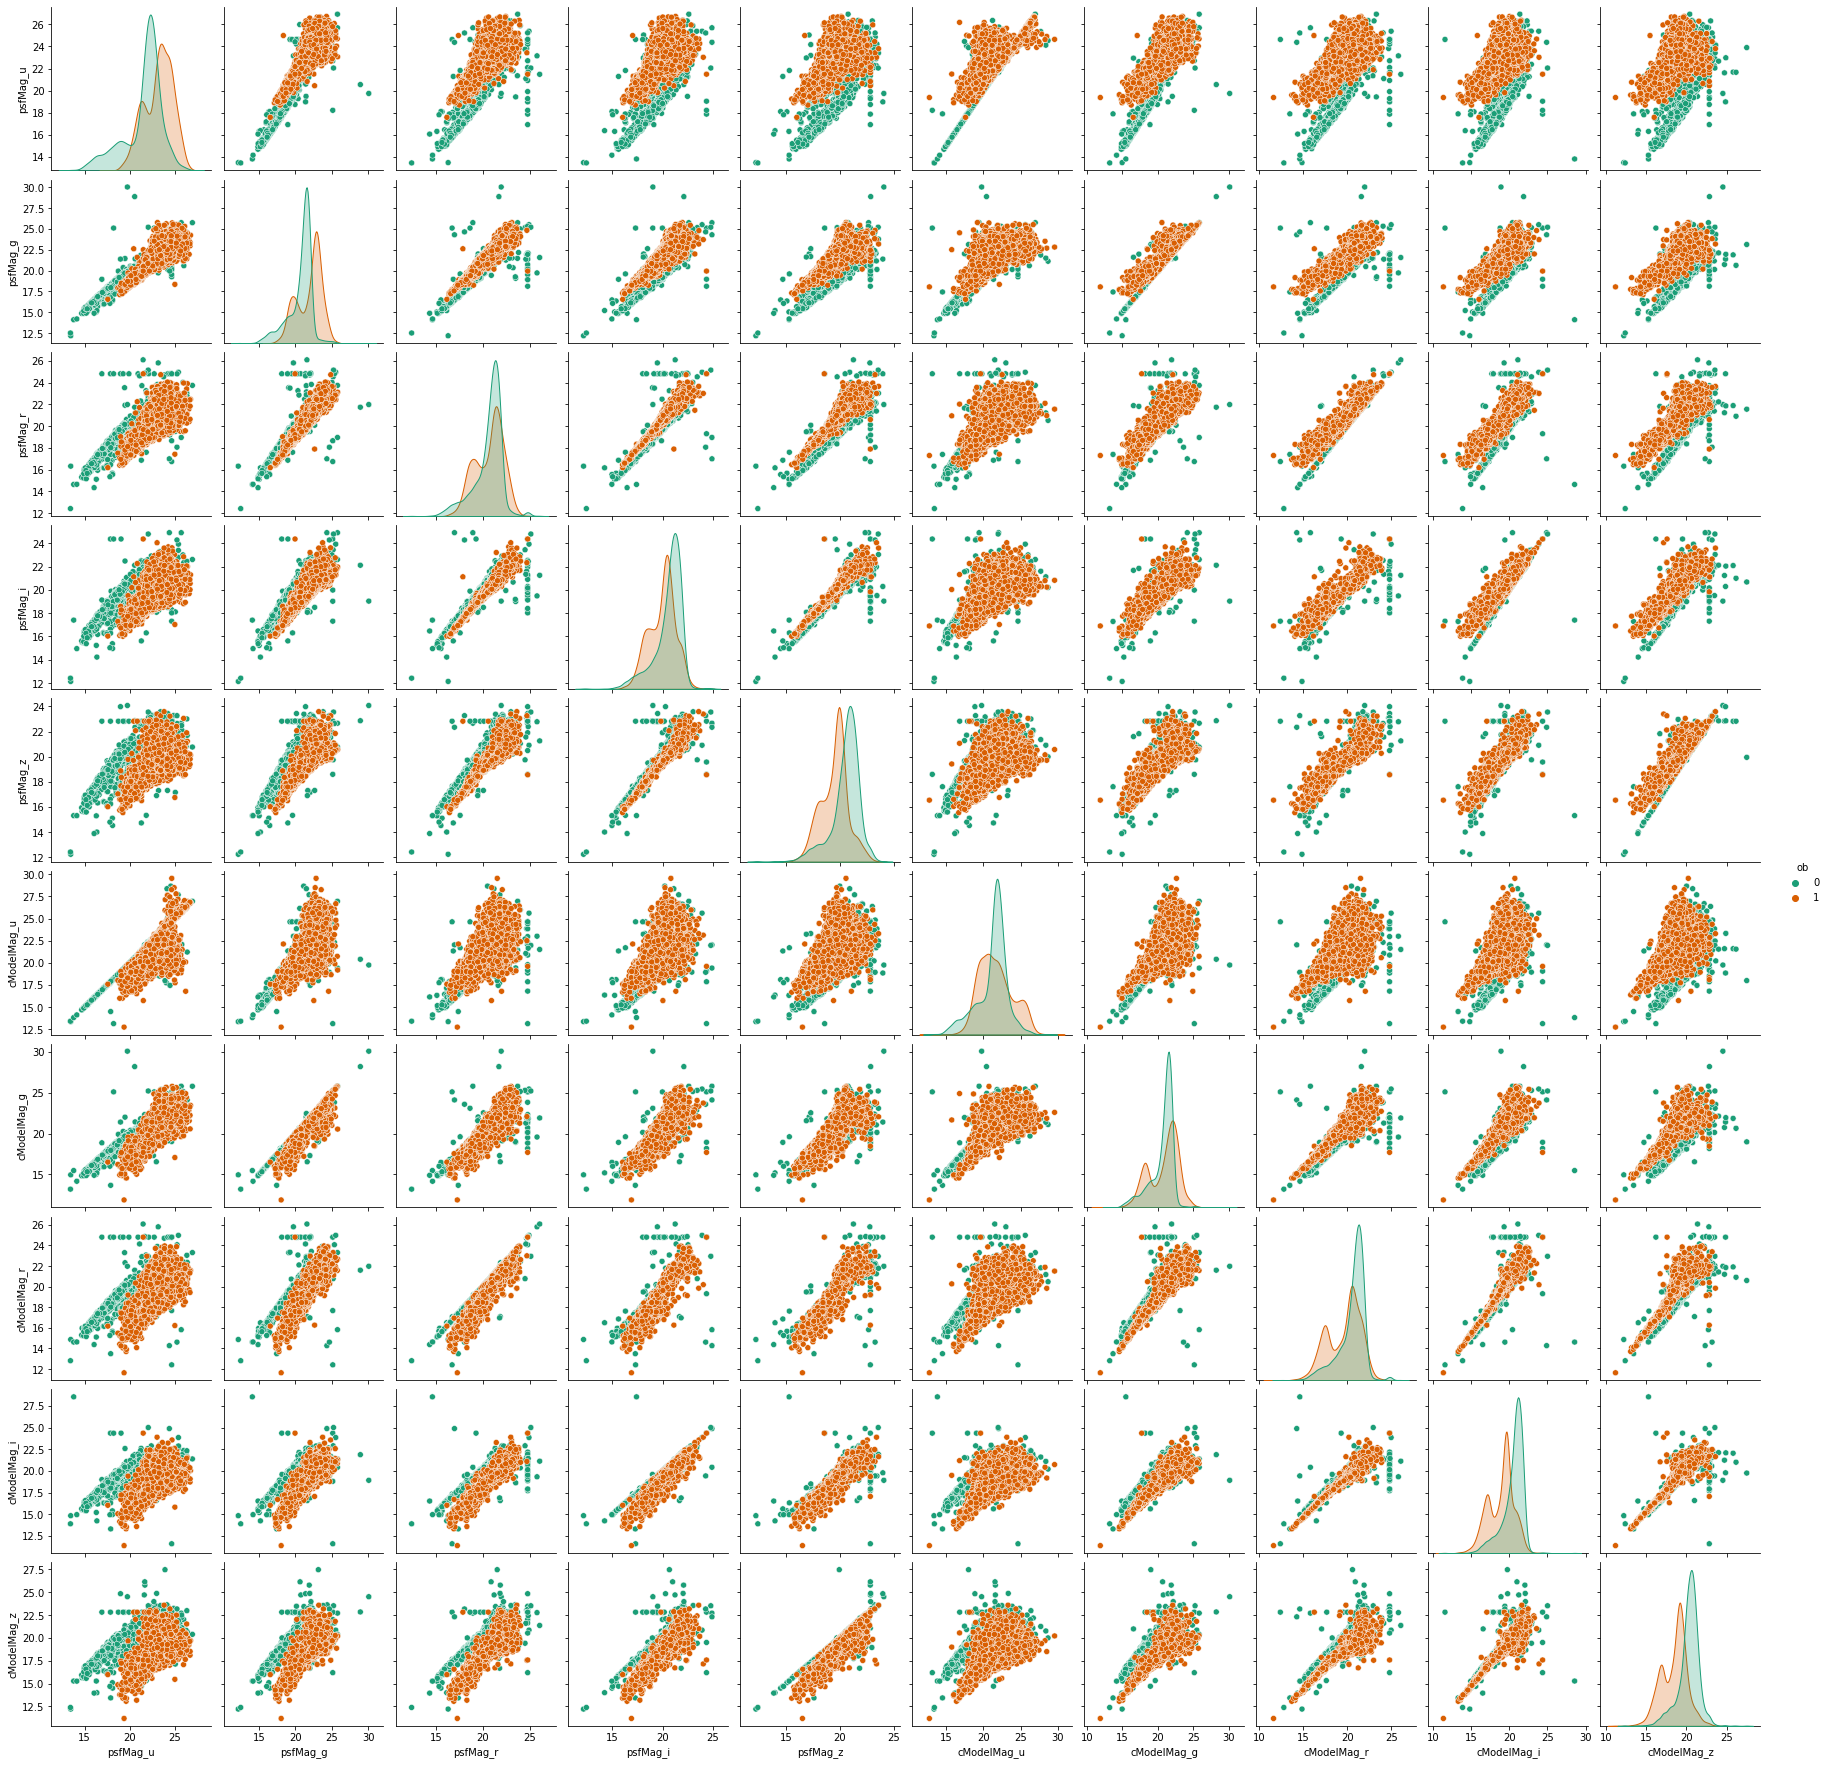

In [72]:
sns.pairplot(data = df0.drop(['class','subClass', 'objID', 'z', 'zErr', 'ra', 'dec'], axis = 1), palette = 'Dark2', hue = 'ob')

Для квазаров:

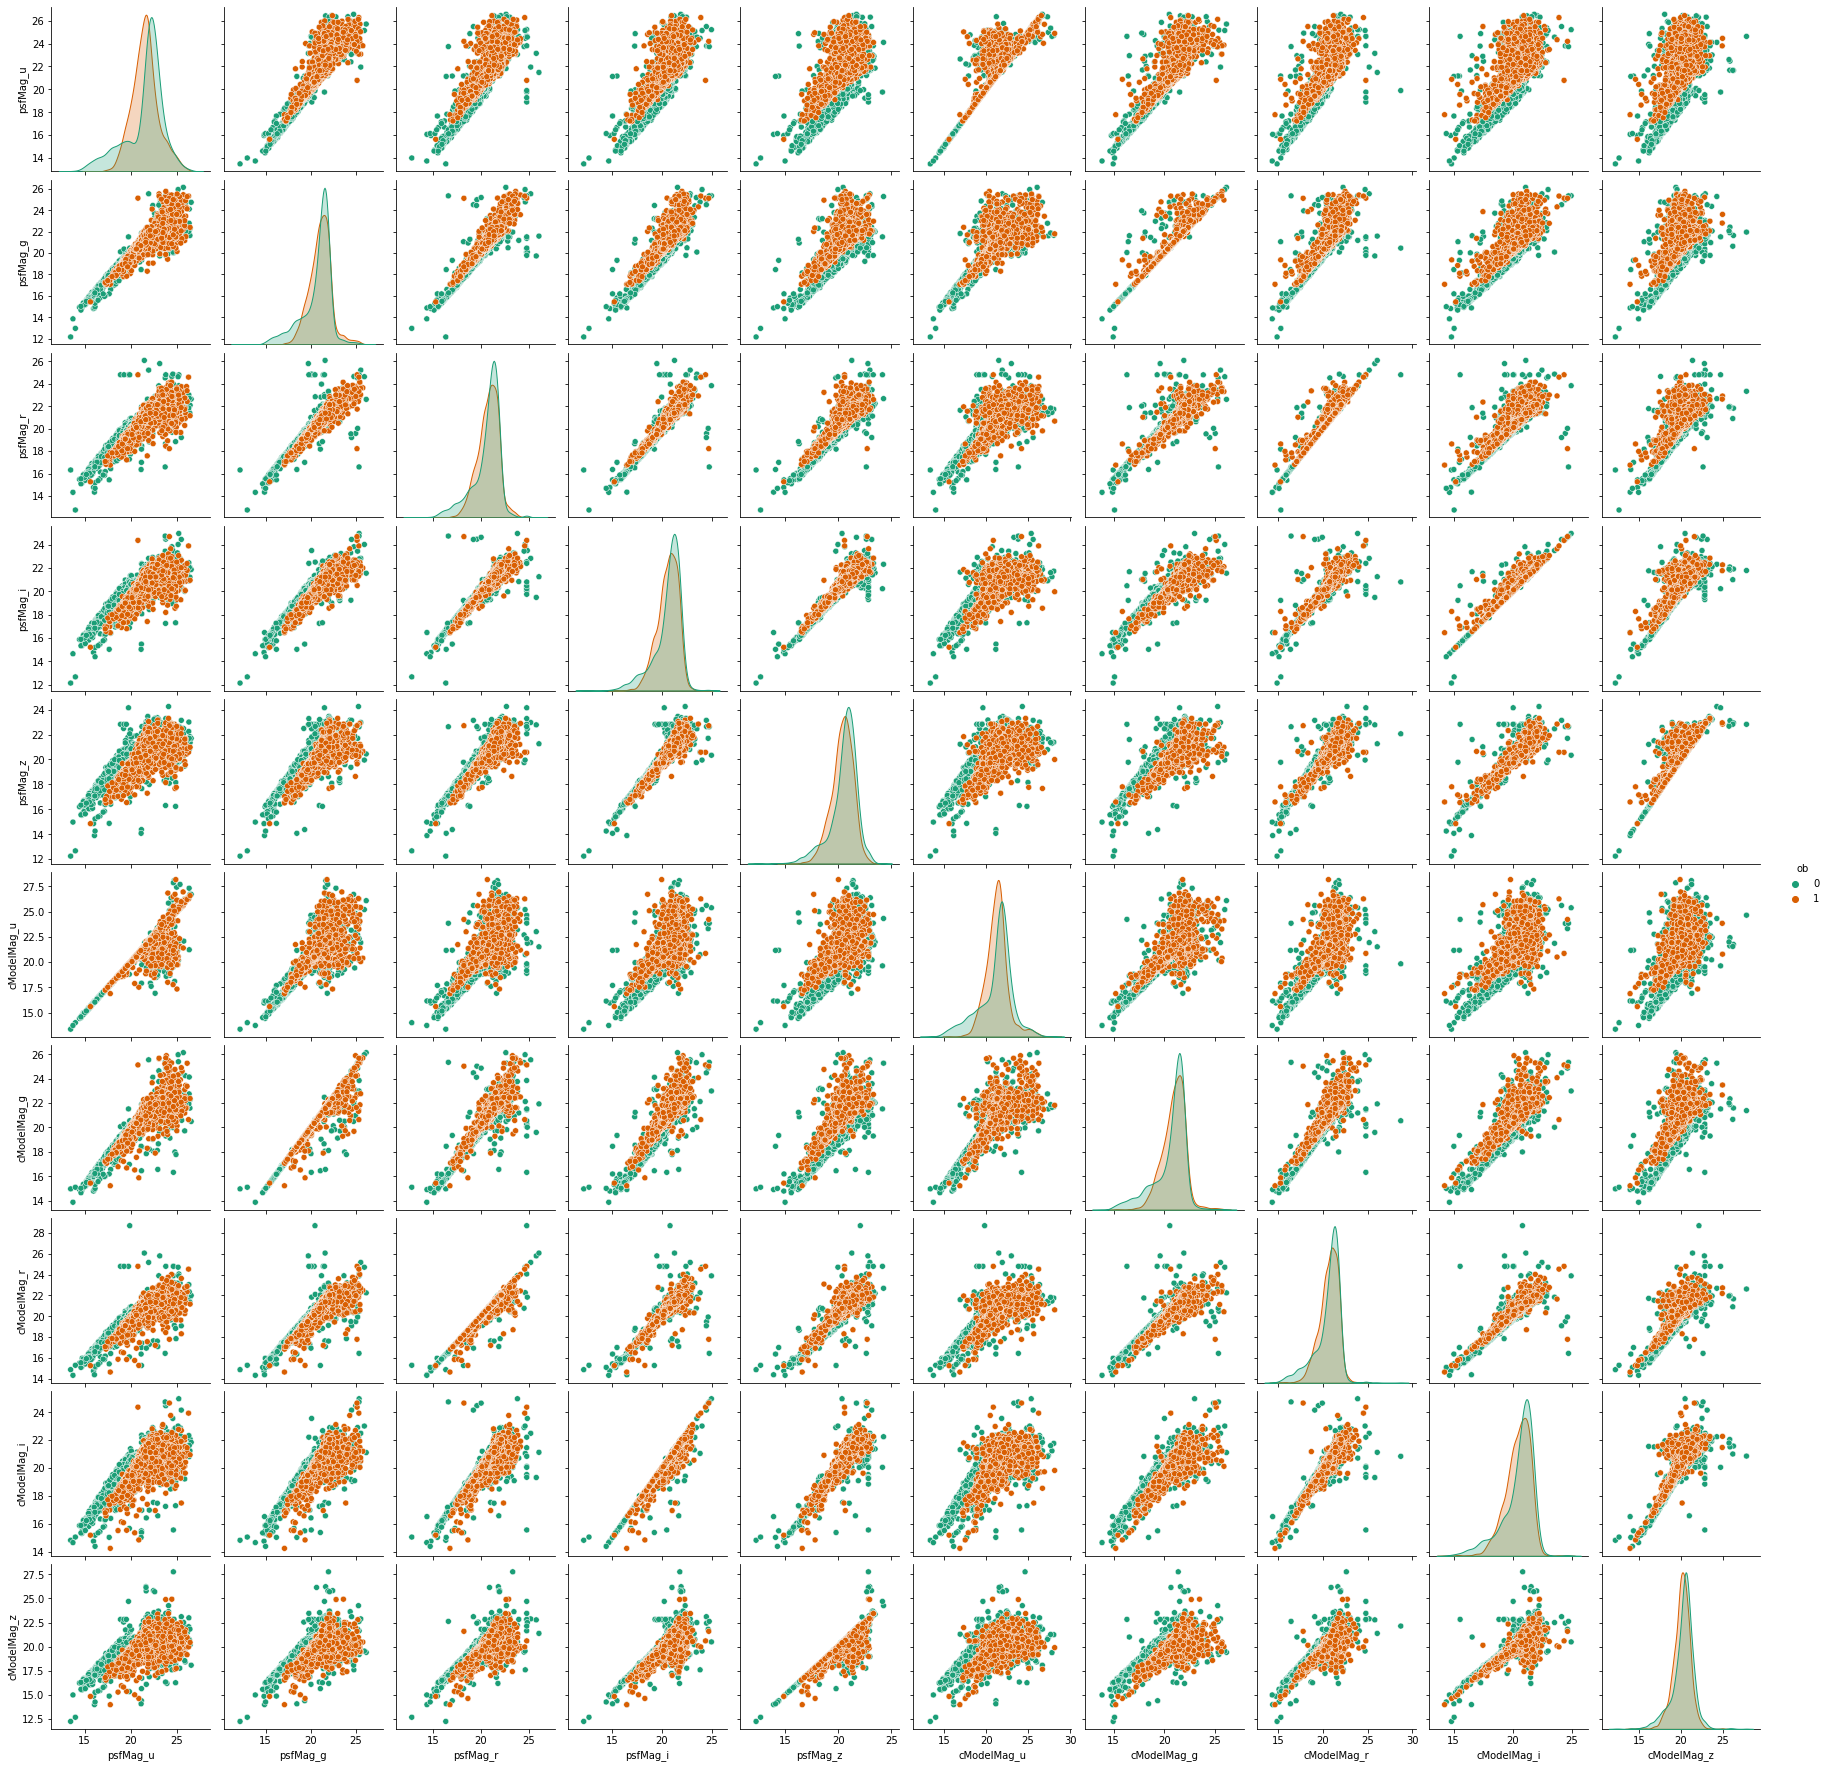

In [17]:
df0 = pd.concat([df[df['ob']==0].sample(3000), df[df['class']==3].sample(3000)])#, df[df['ob']==1][df[df['ob']==1]['class']==1].sample(1000)])
sns.pairplot(data = df0.drop(['class','subClass', 'objID', 'z', 'zErr', 'ra', 'dec'], axis = 1), palette = 'Dark2', hue = 'ob')

Для других звезд:

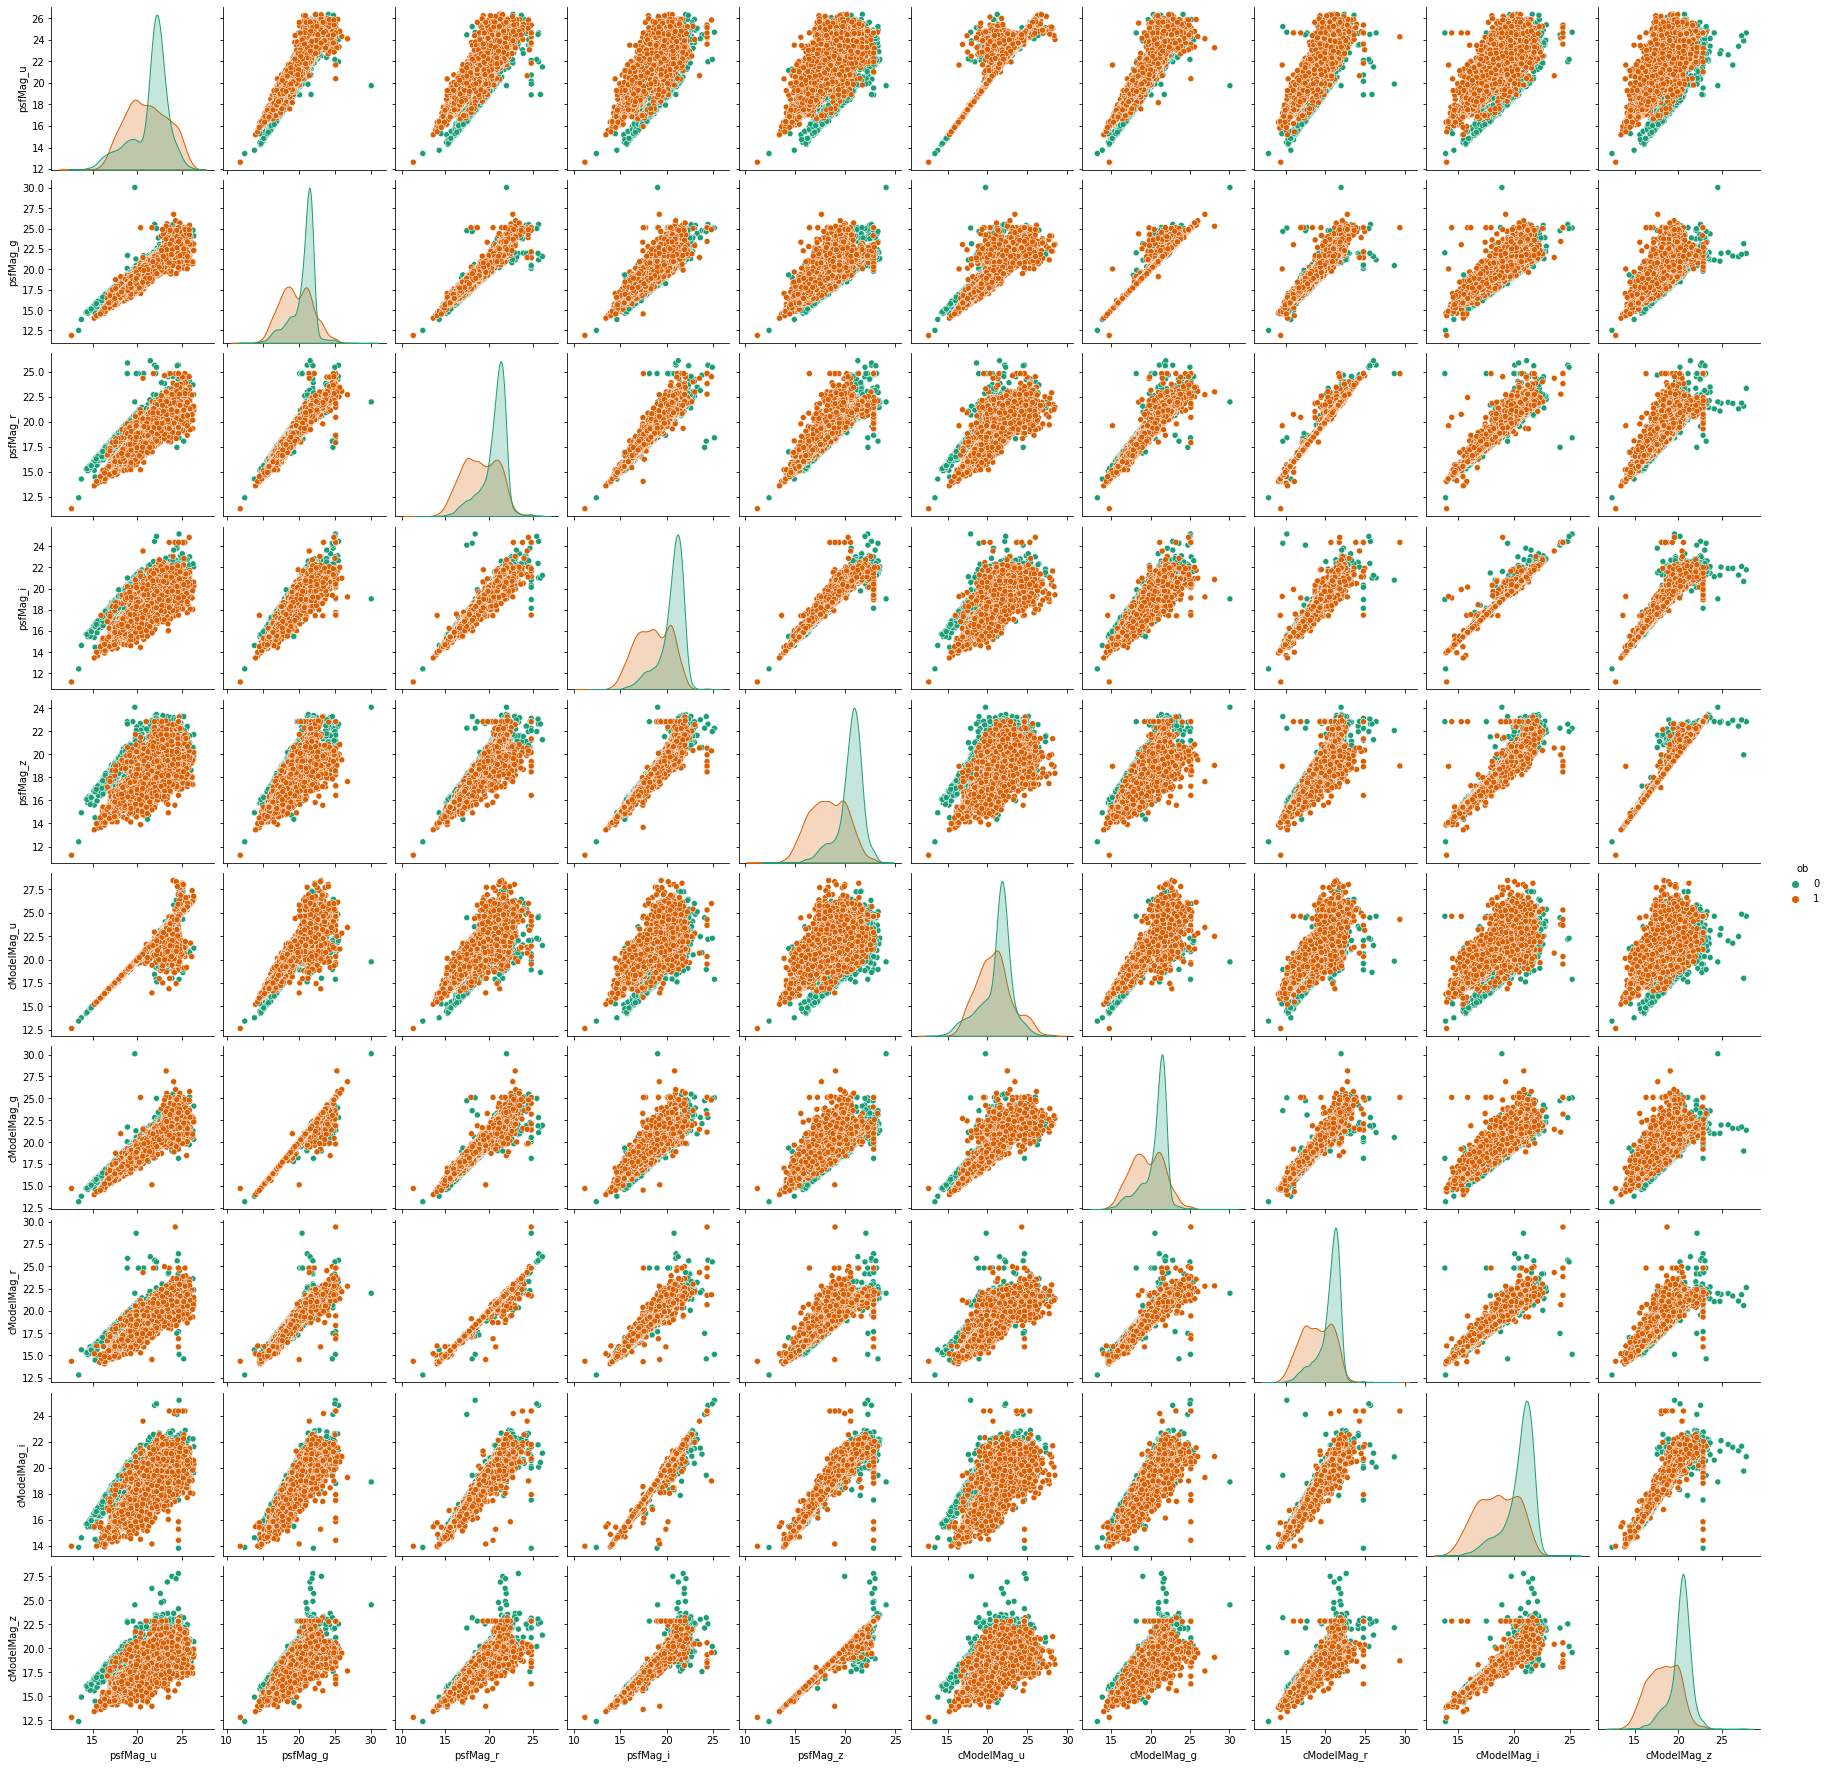

In [84]:
df0 = pd.concat([df[df['ob']==0].sample(3000), df[df['ob']==1][df[df['ob']==1]['class']==1].sample(3000)])
sns.pairplot(data = df0.drop(['class','subClass', 'objID', 'z', 'zErr', 'ra', 'dec'], axis = 1), palette = 'Dark2', hue = 'ob')

In [19]:
def data_preparation(X, y, c, test_size = 0.2): #бработка данных для классификаторов (бинарных и нет)
    count = np.min(((y==1).sum(), (y==0).sum()))
    print(count, (y==0).sum(), (y==1).sum())
    
    X0_train, X0_test, y0_train, y0_test = train_test_split(X[y==0], y[y==0], test_size=test_size, random_state = 43)
    X1_train, X1_test, y1_train, y1_test = train_test_split(X[c==1][y[c==1]==1], y[c==1][y[c==1]==1], test_size=test_size, random_state = 43)
    X2_train, X2_test, y2_train, y2_test = train_test_split(X[c==2], y[c==2], test_size=test_size, random_state = 43)
    X3_train, X3_test, y3_train, y3_test = train_test_split(X[c==3], y[c==3], test_size=test_size, random_state = 43)
    
    count = X0_train.shape[0]
    count1 = X0_test.shape[0]
    i1 = 5
    i2 = 5
    i3 = 5
    X_train, X_test = np.concatenate((X0_train[:count], X1_train[:count//i1], X2_train[:count//i2], X3_train[:count//i3])), np.concatenate((X0_test, X1_test[:count1//3], X2_test[:count1//3], X3_test[:count1//3]))
    y_train, y_test = np.concatenate((y0_train[:count], y1_train[:count//i1], y2_train[:count//i2], y3_train[:count//i3])), np.concatenate((y0_test, y1_test[:count1//3], y2_test[:count1//3], y3_test[:count1//3]))

    X_test_not_scaling = X_test.copy()
    X_train_not_scaling = X_train.copy()

    robust = RobustScaler()

    X_train = robust.fit_transform(X_train)
    X0_test = robust.transform(X0_test)
    X0_train = robust.transform(X0_train)
    X1_test = robust.transform(X1_test)
    X1_train = robust.transform(X1_train)
    X2_test = robust.transform(X2_test)
    X2_train = robust.transform(X2_train)
    X3_test = robust.transform(X3_test)
    X3_train = robust.transform(X3_train)
    X_test = robust.transform(X_test)
    

    return X_train, X_test, y_train, y_test, X_test_not_scaling, X_train_not_scaling, X0_train, X0_test, y0_train, y0_test, X1_train, X1_test, y1_train, y1_test, X2_train, X2_test, y2_train, y2_test, X3_train, X3_test, y3_train, y3_test

In [20]:
X_train, X_test, y_train, y_test, X_test_not_scaling, X_train_not_scaling, X0_train, X0_test, y0_train, y0_test, X1_train, X1_test, y1_train, y1_test, X2_train, X2_test, y2_train, y2_test, X3_train, X3_test, y3_train, y3_test = data_preparation(X, y, c)

13731 13731 4600857


In [21]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(17572, 10) (5492, 10) (17572,) (5492,)


In [344]:
from sklearn.manifold import TSNE
idx = np.random.permutation(17572)
x_tmp = TSNE(3).fit_transform(X_train)
x_tmp = x_tmp[idx]
y_tmp = y_train[idx]

In [326]:
import seaborn as sns

In [327]:
aaa = (y_tmp != 1)
x_aaa = x_tmp[aaa]
y_aaa = y_tmp[aaa]
bbb = (y_tmp != 0)
x_bbb = x_tmp[bbb]
y_bbb = y_tmp[bbb]

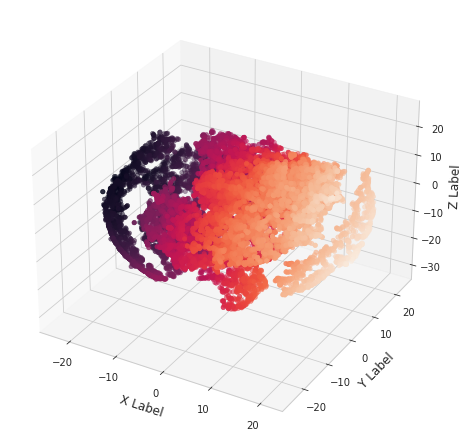

In [346]:
from mpl_toolkits.mplot3d import Axes3D
sns.set_style("whitegrid", {'axes.grid' : False})

fig = plt.figure(figsize=(6,6))

ax = Axes3D(fig) # Method 1
#ax = fig.add_subplot(111, projection='3d') # Method 2

#x = np.random.uniform(1,20,size=20)
#y = np.random.uniform(1,100,size=20)
#z = np.random.uniform(1,100,size=20)
x=x_tmp[:, 0]
y=x_tmp[:, 1]
z=x_tmp[:, 2]


ax.scatter(x, y, z, c=x, marker='o')
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

plt.show()


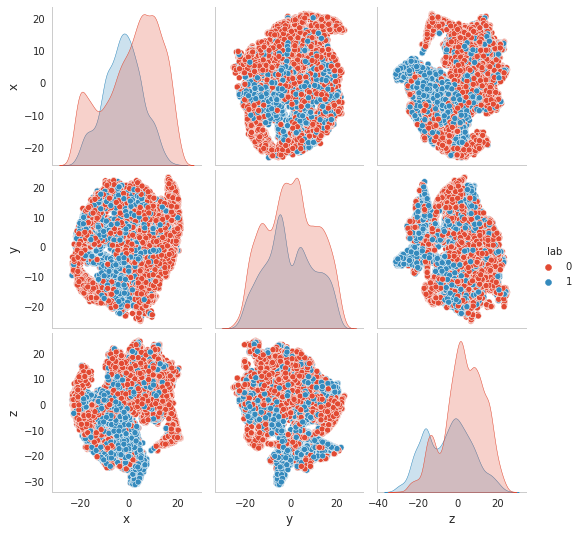

In [347]:
x=x_tmp[:, 0]
y=x_tmp[:, 1]
z=x_tmp[:, 2]

df_3d = pd.DataFrame()
df_3d['x'] = x
df_3d['y'] = y
df_3d['z'] = z
df_3d['lab'] = y_tmp

sns.pairplot(df_3d, hue='lab')

AttributeError: 'PathCollection' object has no property 'z'

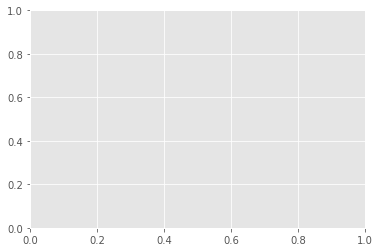

In [328]:
sns.scatterplot(x=x_tmp[:, 0], y=x_tmp[:, 1], z=x_tmp[:, 2], hue=y_tmp)

<AxesSubplot:>

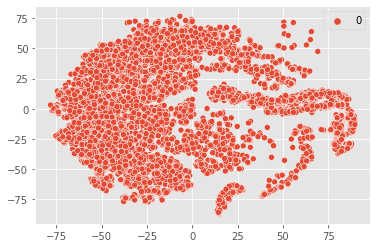

In [321]:
sns.scatterplot(x=x_aaa[:, 0], y=x_aaa[:, 1], hue=y_aaa)

<AxesSubplot:>

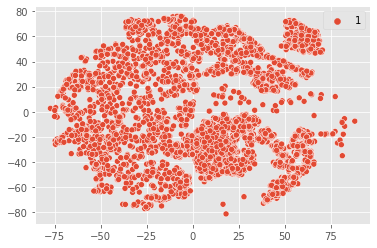

In [324]:
sns.scatterplot(x=x_bbb[:, 0], y=x_bbb[:, 1], hue=y_bbb)

In [22]:
def print_plot2(ml, X_sub, y_sub, X_sub_test_not_scaling):
    
    X_test_not_scaling = X_sub_test_not_scaling[X_sub_test_not_scaling[:,7].argsort()]
    X_test = X_sub[X_sub_test_not_scaling[:,7].argsort()]
    y_test = y_sub[X_sub_test_not_scaling[:,7].argsort()]
    
    #shift = 1000
    #n = len(y_test)//shift
    n = 10
    shift = len(y_test)//n
    precision = []
    recall = []
    f1 = []
    r_mean = []
    y_pred_all = ml.predict(X_test)

    for i in range(0, n):
            h = classification_report(y_test[i*shift : (i+1) * shift], y_pred_all[i*shift : (i+1) * shift], output_dict=True, zero_division=0)
            precision.append(h['0']['precision'])
            recall.append(h['0']['recall'])
            f1.append(h['0']['f1-score'])
            r_mean.append(X_test_not_scaling[i*shift : (i+1) * shift][:,7].mean())
            
    plt.figure(figsize = (5,4))
    plt.title('Зависимость precision от признкака cModelMag_r:')
    plt.plot(r_mean, precision, color='blue', linestyle='dashed', marker='o', markerfacecolor='red', markersize=10)
    plt.figure(figsize = (5,4))
    plt.title('Зависимость recall от признкака cModelMag_r:')
    plt.plot(r_mean, recall, color='blue', linestyle='dashed', marker='o', markerfacecolor='red', markersize=10)
    plt.figure(figsize = (5,4))
    plt.title('Зависимость f1 от признкака cModelMag_r:')
    plt.plot(r_mean, f1, color='blue', linestyle='dashed', marker='o', markerfacecolor='red', markersize=10)

In [23]:
def roc(model, X_test, y_test, lab):
    from sklearn.metrics import roc_curve
    sns.set(font_scale=1.5)
    sns.set_color_codes("muted")

    plt.figure(figsize=(10, 8))
    fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:,1], pos_label=lab)
    lw = 2
    plt.plot(fpr, tpr, lw=lw, label='ROC curve ')
    plt.plot([0, 1], [0, 1])
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve')
    plt.savefig("ROC.png")
    plt.show() 

In [24]:
import time
t = time.time()
rf = RandomForestClassifier(n_estimators=200, random_state=42, max_features=5, min_samples_leaf=1) 
rf.fit(X_train, y_train)
#rf = joblib.load('rf_new.pkl')
y_pred = rf.predict(X_test)
print('Classification Report: \n', classification_report(y_test, y_pred))
print('Confusion Matrix: \n', confusion_matrix(y_test, y_pred))
rf_train_acc = rf.score(X_train, y_train)
print('Training Score: ', rf_train_acc)
rf_test_acc = rf.score(X_test, y_test)
print('Testing Score: ', rf_test_acc)
print(-t + time.time())

Classification Report: 
               precision    recall  f1-score   support

           0       0.82      0.93      0.87      2747
           1       0.92      0.80      0.85      2745

    accuracy                           0.86      5492
   macro avg       0.87      0.86      0.86      5492
weighted avg       0.87      0.86      0.86      5492

Confusion Matrix: 
 [[2550  197]
 [ 550 2195]]
Training Score:  1.0
Testing Score:  0.8639839766933721
26.452980518341064


In [25]:
rf.feature_importances_

array([0.17494596, 0.12259795, 0.05450191, 0.05576137, 0.10785926,
       0.09308071, 0.07842807, 0.04873224, 0.09034012, 0.17375242])

In [86]:
from lightgbm import LGBMClassifier

gb = LGBMClassifier(n_estimators=100, num_leaves=60, learning_rate=0.06, max_depth=10)
gb.fit(X_train, y_train)
pred = gb.predict(X_test)
print('Classification Report: \n', classification_report(y_test, pred))
print('Confusion Matrix: \n', confusion_matrix(y_test, pred))
gb_train_acc = gb.score(X_train, y_train)
print('Training Score: ', gb_train_acc)
gb_test_acc = gb.score(X_test, y_test)
print('Testing Score: ', gb_test_acc)

Classification Report: 
               precision    recall  f1-score   support

           0       0.82      0.93      0.87      2747
           1       0.92      0.80      0.85      2745

    accuracy                           0.86      5492
   macro avg       0.87      0.86      0.86      5492
weighted avg       0.87      0.86      0.86      5492

Confusion Matrix: 
 [[2543  204]
 [ 544 2201]]
Training Score:  0.9024584566355566
Testing Score:  0.8638018936635106


In [27]:
gb.feature_importances_

array([1093,  684,  482,  479,  709,  484,  490,  399,  469,  587],
      dtype=int32)

In [ ]:
print_plot2(rf, X_test[y_test==0], y_test[y_test==0], X_test_not_scaling[y_test==0])

In [ ]:
print_plot2(gb, X_test[y_test==0], y_test[y_test==0], X_test_not_scaling[y_test==0])

In [61]:
X_pr, y_pr = np.concatenate((X0_test, X1_test)), np.concatenate((y0_test, y1_test))
y_pred = gb.predict(X_pr) #результаты на большой выборке только звезд
print('Classification Report: \n', classification_report(y_pr, y_pred))
print('Confusion Matrix: \n', confusion_matrix(y_pr, y_pred))

Classification Report: 
               precision    recall  f1-score   support

           0       0.05      0.93      0.10      2747
           1       1.00      0.76      0.86    189327

    accuracy                           0.76    192074
   macro avg       0.53      0.84      0.48    192074
weighted avg       0.99      0.76      0.85    192074

Confusion Matrix: 
 [[  2543    204]
 [ 44977 144350]]


In [62]:
X_pr, y_pr = np.concatenate((X0_test, X2_test)), np.concatenate((y0_test, y2_test))
y_pred = gb.predict(X_pr)#результаты на большой выборке только галактик
print('Classification Report: \n', classification_report(y_pr, y_pred))
print('Confusion Matrix: \n', confusion_matrix(y_pr, y_pred))

Classification Report: 
               precision    recall  f1-score   support

           0       0.13      0.93      0.22      2747
           1       1.00      0.97      0.98    557811

    accuracy                           0.97    560558
   macro avg       0.56      0.95      0.60    560558
weighted avg       1.00      0.97      0.98    560558

Confusion Matrix: 
 [[  2543    204]
 [ 17619 540192]]


In [63]:
X_pr, y_pr = np.concatenate((X0_test, X3_test)), np.concatenate((y0_test, y3_test))
y_pred = rf.predict(X_pr)#результаты на большой выборке только квазаров 
print('Classification Report: \n', classification_report(y_pr, y_pred))
print('Confusion Matrix: \n', confusion_matrix(y_pr, y_pred))

Classification Report: 
               precision    recall  f1-score   support

           0       0.04      0.93      0.08      2747
           1       1.00      0.68      0.81    173035

    accuracy                           0.69    175782
   macro avg       0.52      0.80      0.45    175782
weighted avg       0.98      0.69      0.80    175782

Confusion Matrix: 
 [[  2550    197]
 [ 55173 117862]]


In [141]:
#плохо работает с квазарами 

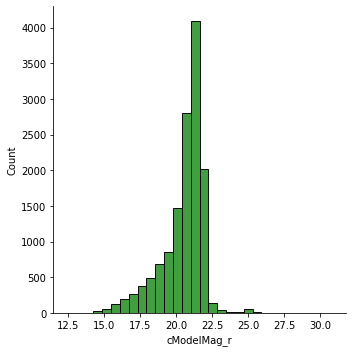

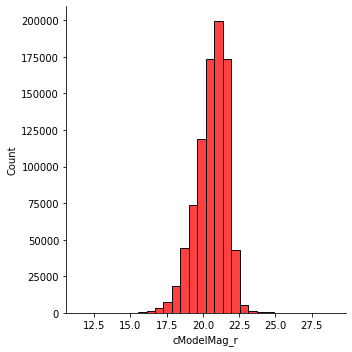

In [30]:
sns.displot(df[df['ob'] == 0].cModelMag_r,  bins = 30, color = 'g')
sns.displot(df[df['class'] == 3].cModelMag_r,  bins = 30, color = 'r')

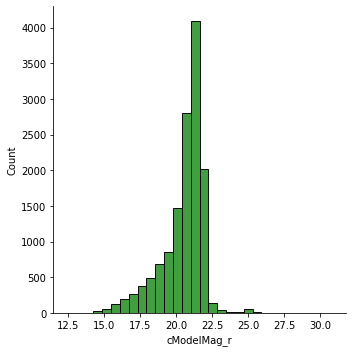

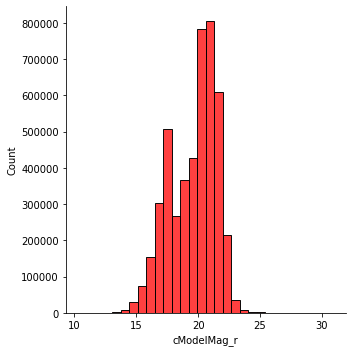

In [66]:
#fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize = (24, 6))
sns.displot(df[df['ob'] == 0].cModelMag_r,  bins = 30, color = 'g')
sns.displot(df[df['ob'] == 1].cModelMag_r,  bins = 30, color = 'r')

/home/nadia/.local/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

/home/nadia/.local/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



<AxesSubplot:xlabel='cModelMag_z', ylabel='Density'>

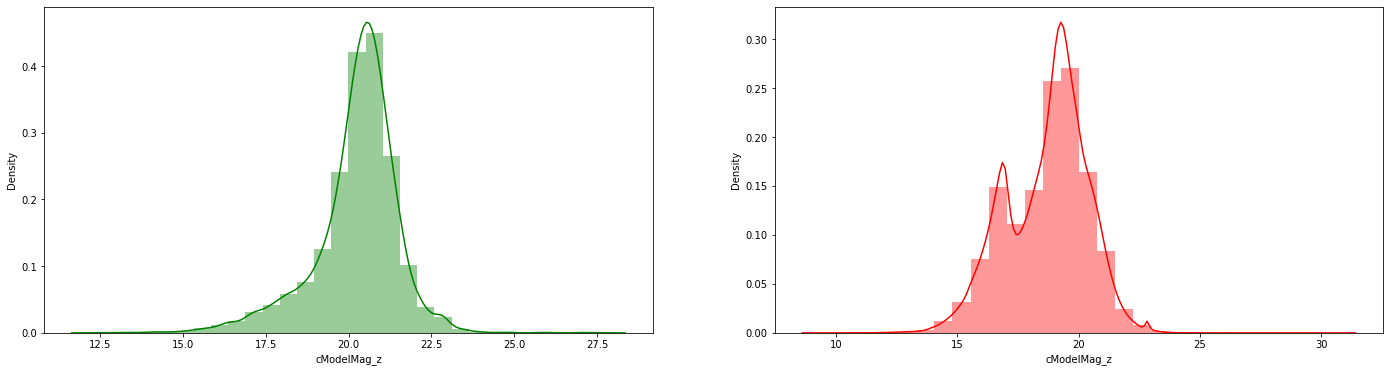

In [78]:
fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize = (24, 6))
sns.distplot(df[df['ob'] == 0].cModelMag_z, ax = ax1,  bins = 30, color = 'g') #самый значимый параметр для классификации 
sns.distplot(df[df['ob'] == 1].cModelMag_z, ax = ax2,  bins = 30, color = 'r')

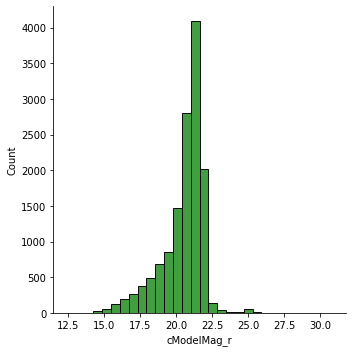

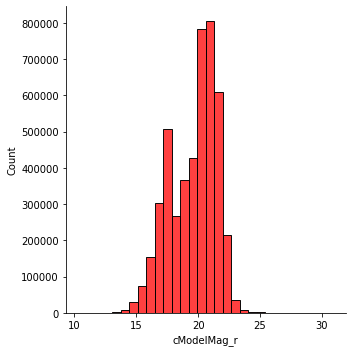

In [66]:
#fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize = (24, 6))
sns.displot(df[df['ob'] == 0].cModelMag_r,  bins = 30, color = 'g')
sns.displot(df[df['ob'] == 1].cModelMag_r,  bins = 30, color = 'r')

<AxesSubplot:xlabel='ob', ylabel='cModelMag_z'>

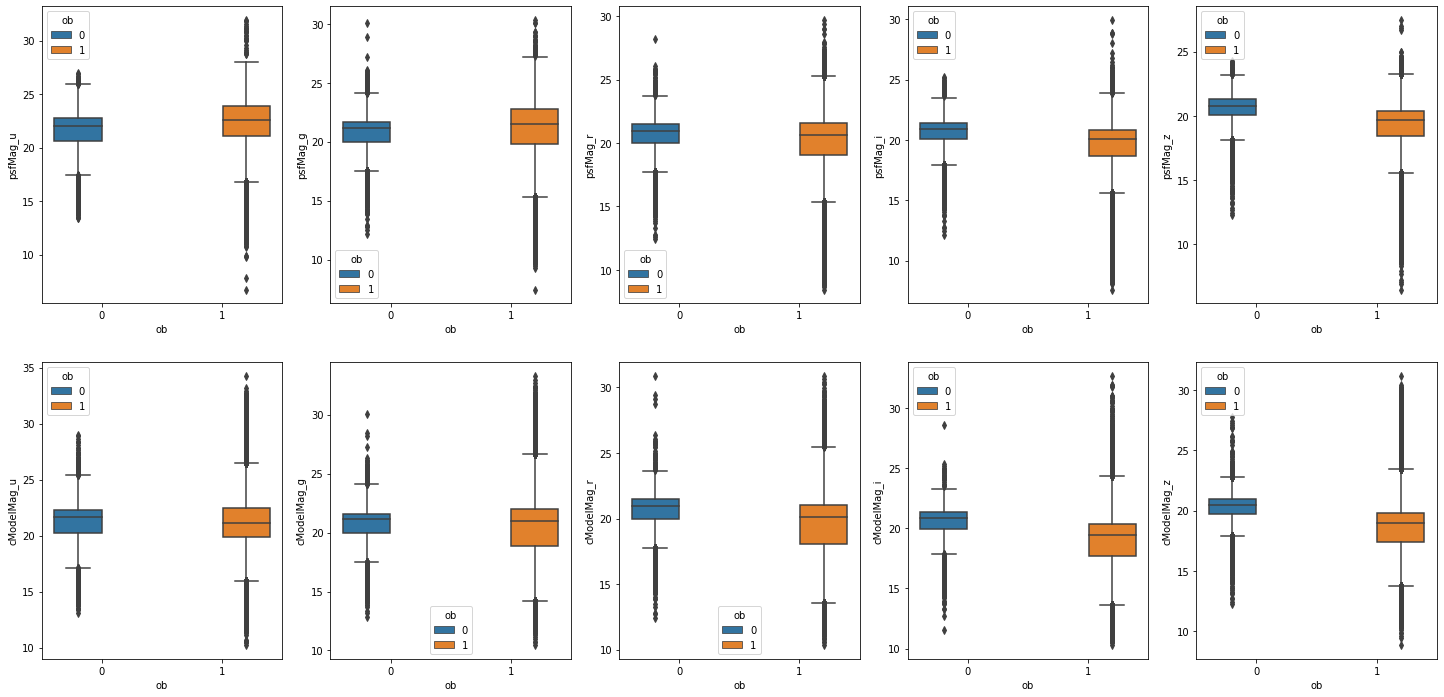

In [70]:
fig, ((ax1, ax2, ax3, ax4, ax5), (ax6, ax7, ax8, ax9, ax10)) = plt.subplots(nrows=2, ncols=5, figsize = (25, 12))
sns.boxplot(ax=ax1, x = 'ob', y = 'psfMag_u', hue = 'ob', data = df) 
sns.boxplot(ax=ax2, x = 'ob', y = 'psfMag_g', hue = 'ob', data = df)
sns.boxplot(ax=ax3, x = 'ob', y = 'psfMag_r', hue = 'ob', data = df)
sns.boxplot(ax=ax4, x = 'ob', y = 'psfMag_i', hue = 'ob', data = df)
sns.boxplot(ax=ax5, x = 'ob', y = 'psfMag_z', hue = 'ob', data = df)
sns.boxplot(ax=ax6, x = 'ob', y = 'cModelMag_u', hue = 'ob', data = df)
sns.boxplot(ax=ax7, x = 'ob', y = 'cModelMag_g', hue = 'ob', data = df)
sns.boxplot(ax=ax8, x = 'ob', y = 'cModelMag_r', hue = 'ob', data = df)
sns.boxplot(ax=ax9, x = 'ob', y = 'cModelMag_i', hue = 'ob', data = df)
sns.boxplot(ax=ax10,x = 'ob', y = 'cModelMag_z', hue = 'ob', data = df)

In [84]:
joblib.dump(rf, 'rf_new.pkl')
#rf = rf = joblib.load('rf_new.pkl')

['rf_new.pkl']

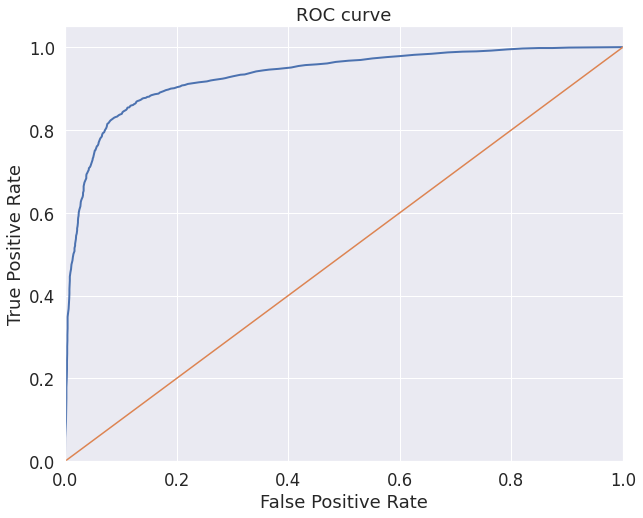

In [76]:
roc(rf, X_test, y_test, 1)

Точность увеличивается для более слабых объектов, что кажется неправдоподобным 

auc = 0.8639605517660265


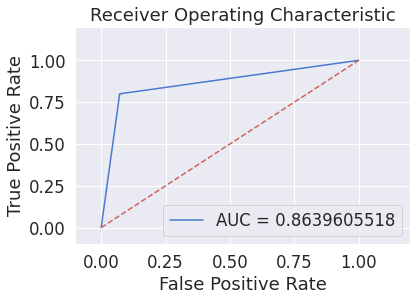

In [78]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_test, rf.predict(X_test), drop_intermediate=False)
#fpr, tpr, thresholds = roc_curve(y2_test, rf2.predict(X2_test))
auc = auc(fpr, tpr)
print('auc =', auc)

plt.figure()
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b',
label='AUC = %0.10f'% auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

Text(0.5, 1.0, '2-class Precision-Recall')

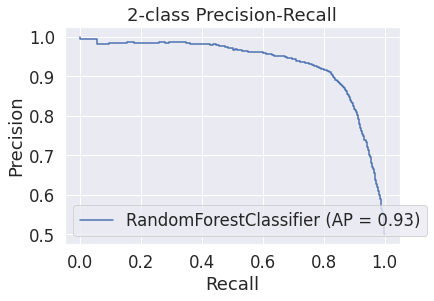

In [79]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve
import matplotlib.pyplot as plt

disp = plot_precision_recall_curve(rf, X_test, y_test)
disp.ax_.set_title('2-class Precision-Recall')

In [30]:
joblib.dump(rf2, 'rf2_new.pkl')

['rf2_new.pkl']

roc и precision-recall кривые для объектов с плохой точностью: 

In [148]:
#index = (df['cModelMag_r'] < 22.5) & (df['cModelMag_r'] > 21)
X_train_rf, X_test_rf, y_train_rf, y_test_rf, X_test_not_scaling_rf, X_train_not_scaling_rf = X_train, X_test, y_train, y_test, X_test_not_scaling, X_train_not_scaling#data_preparation(X2[index], y2[index], test_size=0.8)

auc = 0.8637793307221058


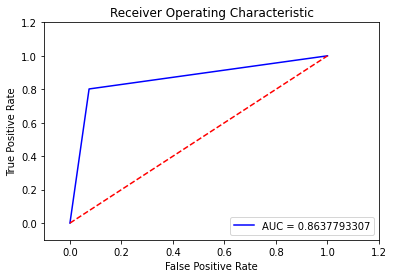

In [32]:
from sklearn.metrics import roc_curve, auc
#y_pred_rf = gb.predict_proba(X_test_rf)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, gb.predict(X_test), drop_intermediate=False)
#fpr, tpr, thresholds = roc_curve(y2_test, rf2.predict(X2_test))
auc = auc(fpr, tpr)
print('auc =', auc)

plt.figure()
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b',
label='AUC = %0.10f'% auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

Text(0.5, 1.0, '2-class Precision-Recall')

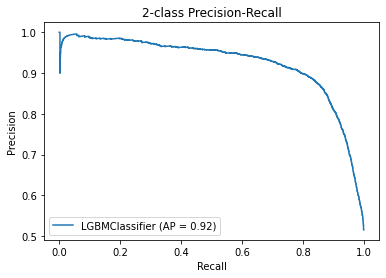

In [153]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve
import matplotlib.pyplot as plt

disp = plot_precision_recall_curve(gb, X_test_rf, y_test_rf)
disp.ax_.set_title('2-class Precision-Recall')

In [82]:
error_rate = []
for i in range(1,40):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train, y_train)
    pred_i = knn.predict(X_test)
    error_rate.append(np.mean(pred_i != y_test))

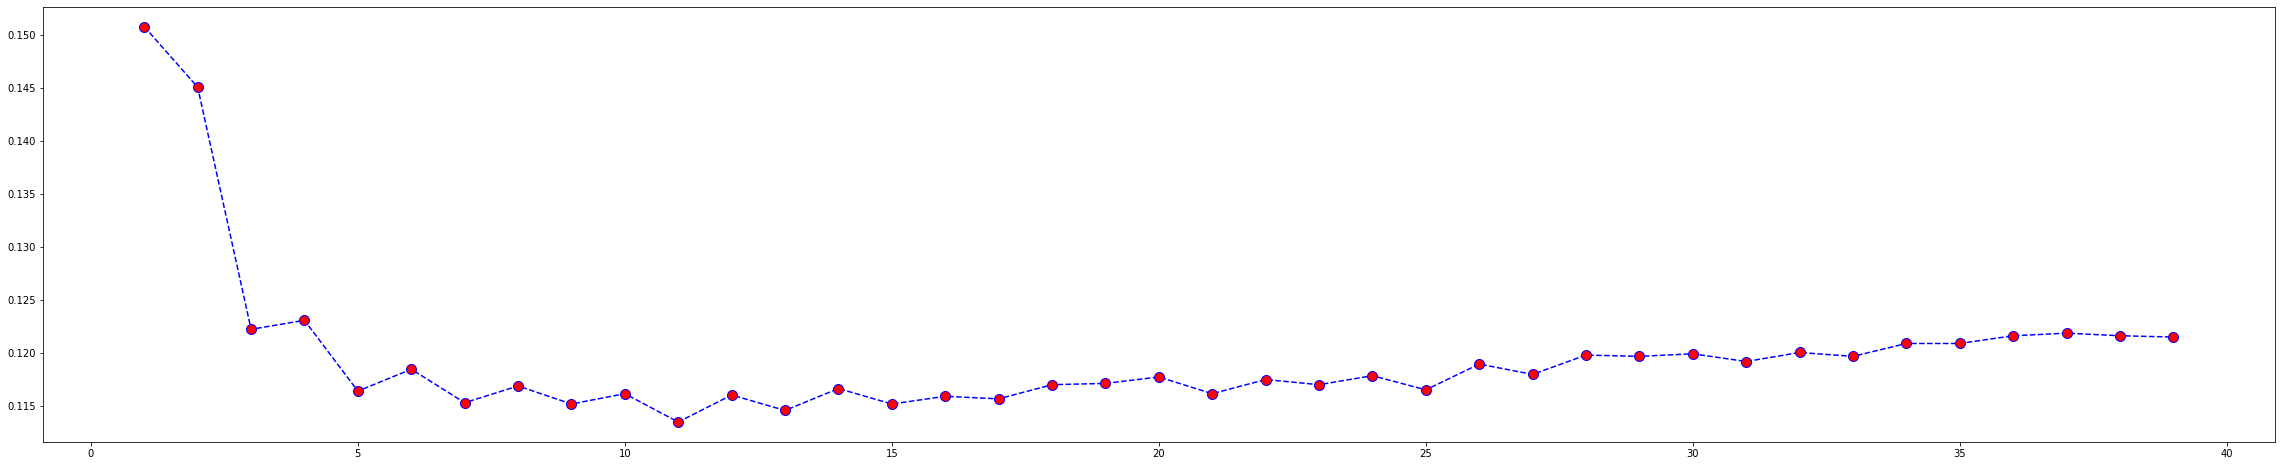

In [84]:
plt.figure(figsize = (40,8))
plt.plot(range(1,40), error_rate, color='blue', linestyle='dashed', marker='o', markerfacecolor='red', markersize=10)

In [80]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
print('Classification Report: \n', classification_report(y_test, y_pred))
print('Confusion Matrix: \n', confusion_matrix(y_test, y_pred))
knn_train_acc = knn.score(X_train, y_train)
print('Training Score: ', knn_train_acc)
knn_test_acc = knn.score(X_test, y_test)
print('Testing Score: ', knn_test_acc)

Classification Report: 
               precision    recall  f1-score   support

           0       0.80      0.93      0.86      2747
           1       0.92      0.77      0.84      2745

    accuracy                           0.85      5492
   macro avg       0.86      0.85      0.85      5492
weighted avg       0.86      0.85      0.85      5492

Confusion Matrix: 
 [[2562  185]
 [ 625 2120]]
Training Score:  0.8940359663100387
Testing Score:  0.8525127458120904


# Функции для подбора параметров классификаторов

In [155]:
def CV(RFC, X, y):
    temp_train_acc = []
    temp_test_acc = []
    temp_train_f1 = []
    temp_test_f1 = []

    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        RFC.fit(X_train, y_train)
        train_ans = RFC.predict(X_train)
        test_ans = RFC.predict(X_test)
        temp_train_acc.append(accuracy_score(y_train, train_ans)) 
        temp_train_f1.append(f1_score(y_train, train_ans, average="binary"))
        temp_test_acc.append(accuracy_score(y_test, test_ans))
        temp_test_f1.append(f1_score(y_test, test_ans, average="binary"))
    return temp_train_acc, temp_test_acc, temp_train_f1, temp_test_f1

In [174]:
def visualize(test_metric_acc, train_metric_acc, test_metric_f1, train_metric_f1, grid, xlabel ='X'):
        train_acc, tast_acc = np.asarray(train_metric_acc), np.asarray(test_metric_acc)
        train_f1, test_f1 = np.asarray(train_metric_f1), np.asarray(test_metric_f1)
        print("Best accuracy_store is", max(np.mean(test_acc, axis=1)), "with",
                                    grid[np.argmax(np.mean(test_acc, axis=1))], xlabel)
        plt.style.use('ggplot')
        plt.figure(figsize=(16, 8))
        plt.title("Accuracy")
        plt.plot(grid, np.mean(test_acc, axis=1), label="test")
        plt.plot(grid, np.mean(train_acc, axis=1), label="train")
        plt.xlabel(xlabel)
        plt.legend()
        plt.show()
                  
        print("Лучший f1_score ", max(np.mean(test_f1, axis=1)), "with",
                                    grid[np.argmax(np.mean(test_f1, axis=1))],  xlabel)
        plt.style.use('ggplot')
        plt. figure(figsize=(16, 8))
        plt.title("F1_score")
        plt.plot(grid, np.mean(test_f1, axis=1), label="test")
        plt.plot(grid, np.mean(train_f1, axis=1), label="train")
        plt.xlabel(xlabel)
        plt.legend()
        plt.show()

In [36]:
def Anv(RFC,X_train, y_train, X_test, y_test):
    
    #print('я обучаюсь')

    RFC.fit(X_train, y_train)
    
    #print('я обучился')
    
    train_ans = RFC.predict(X_train)
    test_ans = RFC.predict(X_test)
    temp_train_acc = accuracy_score(y_train, train_ans)
    temp_train_f1 = classification_report(y_train, train_ans, output_dict=True, zero_division=0)['0']['f1-score']
    temp_test_acc = accuracy_score(y_test, test_ans)
    temp_test_f1 = classification_report(y_test, test_ans, output_dict=True, zero_division=0)['0']['f1-score']
    return temp_train_acc, temp_test_acc, temp_train_f1, temp_test_f1

In [213]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=43)

In [159]:
train_acc = []
test_acc = []
train_f1 = []
test_f1 = []
trees_grid = [5, 10, 15, 30, 50, 100, 150, 200]
for ntrees in tqdm(trees_grid):
    GB = LGBMClassifier(n_estimators=ntrees, random_state=42)
    temp_train_acc, temp_test_acc, temp_train_f1, temp_test_f1 = CV(GB, np.concatenate((X_train_rf, X_test_rf)), np.concatenate((y_train_rf, y_test_rf)))
    train_acc.append(temp_train_acc)
    test_acc.append(temp_test_acc)
    train_f1.append(temp_train_f1)
    test_f1.append(temp_test_f1)

Best accuracy_store is 0.847285803554229 with 150 trees number


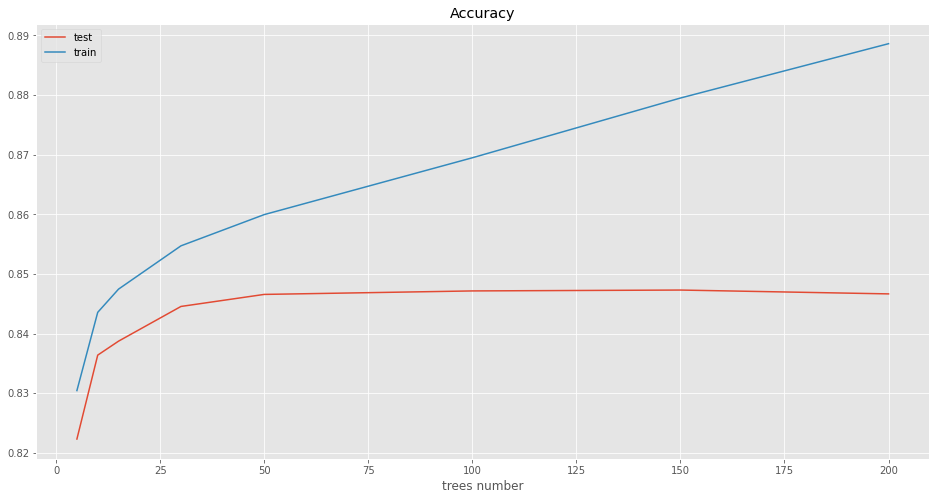

Лучший f1_score  0.8705874248744012 with 150 trees number


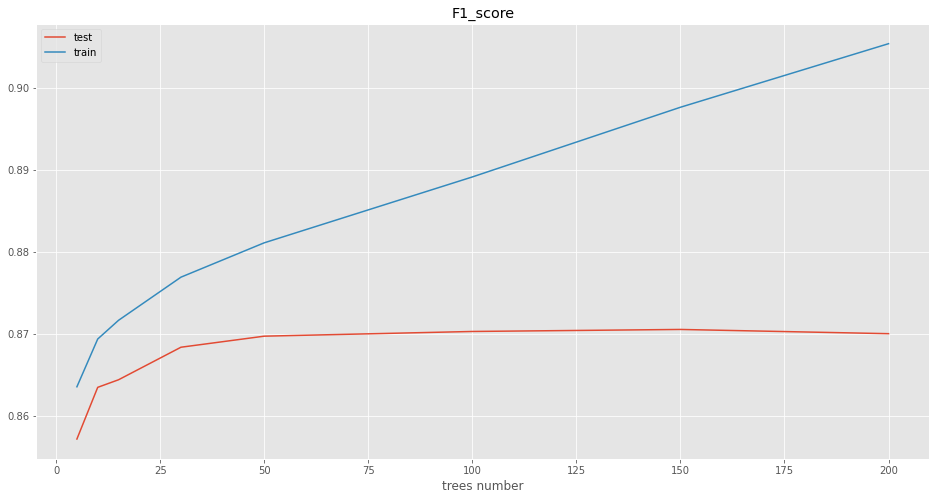

In [175]:
visualize(test_acc, train_acc, test_f1, train_f1, trees_grid, "trees number")

In [214]:
train_acc = []
test_acc = []
train_f1 = []
test_f1 = []
trees_grid = ['gbdt', 'dart', 'goss']
for ntrees in tqdm(trees_grid):
    GB = LGBMClassifier(n_estimators=150, random_state=42, boosting_type=ntrees)
    temp_train_acc, temp_test_acc, temp_train_f1, temp_test_f1 = CV(GB, np.concatenate((X_train_rf, X_test_rf)), np.concatenate((y_train_rf, y_test_rf)))
    train_acc.append(temp_train_acc)
    test_acc.append(temp_test_acc)
    train_f1.append(temp_train_f1)
    test_f1.append(temp_test_f1)

Best accuracy_store is 0.8473150561503967 with dart boosting_type


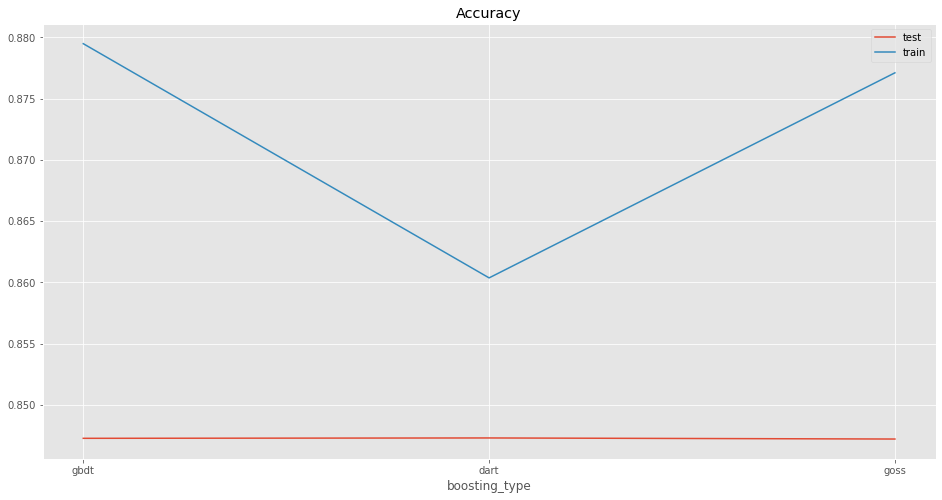

Лучший f1_score  0.8706830077296017 with goss boosting_type


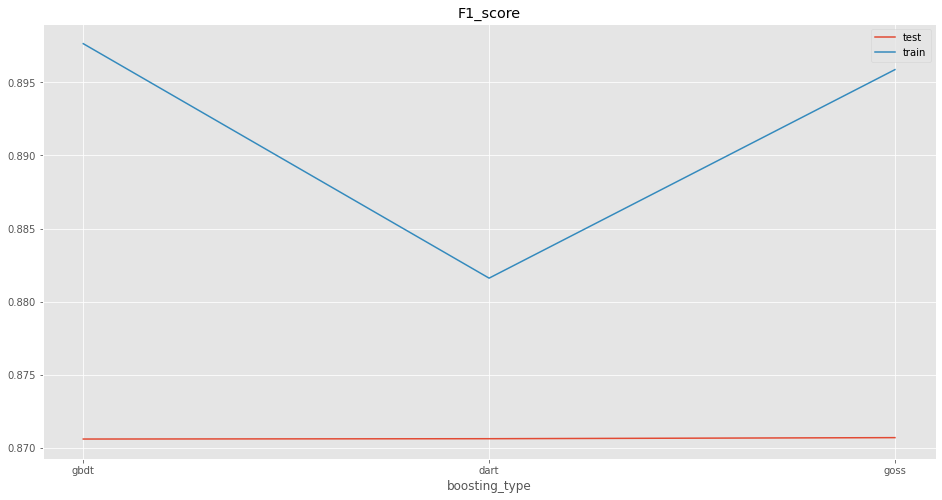

In [216]:
visualize(test_acc, train_acc, test_f1, train_f1, trees_grid, "boosting_type")

In [219]:
train_acc = []
test_acc = []
train_f1 = []
test_f1 = []
trees_grid = [ 5, 10, 31, 60, 100]
for ntrees in tqdm(trees_grid):
    GB = LGBMClassifier(n_estimators=150, random_state=42, num_leaves=ntrees)
    temp_train_acc, temp_test_acc, temp_train_f1, temp_test_f1 = CV(GB, np.concatenate((X_train_rf, X_test_rf)), np.concatenate((y_train_rf, y_test_rf)))
    train_acc.append(temp_train_acc)
    test_acc.append(temp_test_acc)
    train_f1.append(temp_train_f1)
    test_f1.append(temp_test_f1)

Best accuracy_store is 0.8474613062973978 with 60 num_leaves


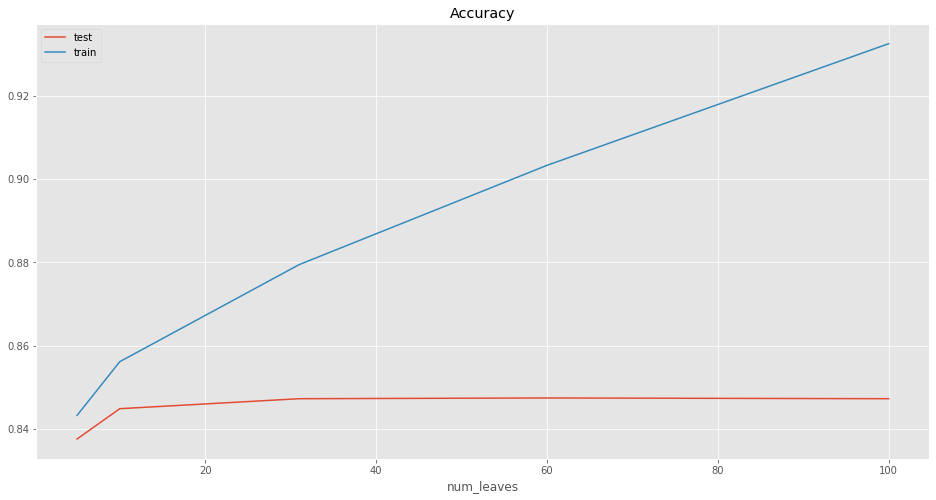

Лучший f1_score  0.8708232804326475 with 60 num_leaves


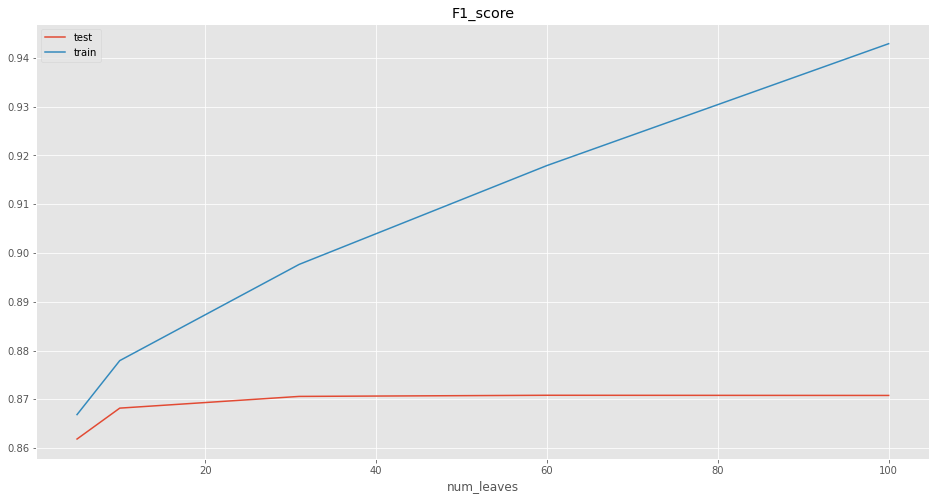

In [220]:
visualize(test_acc, train_acc, test_f1, train_f1, trees_grid, "num_leaves")

In [223]:
train_acc = []
test_acc = []
train_f1 = []
test_f1 = []
trees_grid = [1, 2, 3, 4, 5, 10, 20]
for ntrees in tqdm(trees_grid):
    GB = LGBMClassifier(n_estimators=150, random_state=42, num_leaves=60, max_depth=ntrees)
    temp_train_acc, temp_test_acc, temp_train_f1, temp_test_f1 = CV(GB, np.concatenate((X_train_rf, X_test_rf)), np.concatenate((y_train_rf, y_test_rf)))
    train_acc.append(temp_train_acc)
    test_acc.append(temp_test_acc)
    train_f1.append(temp_train_f1)
    test_f1.append(temp_test_f1)

Best accuracy_store is 0.8476368646538675 with 10 max_depth


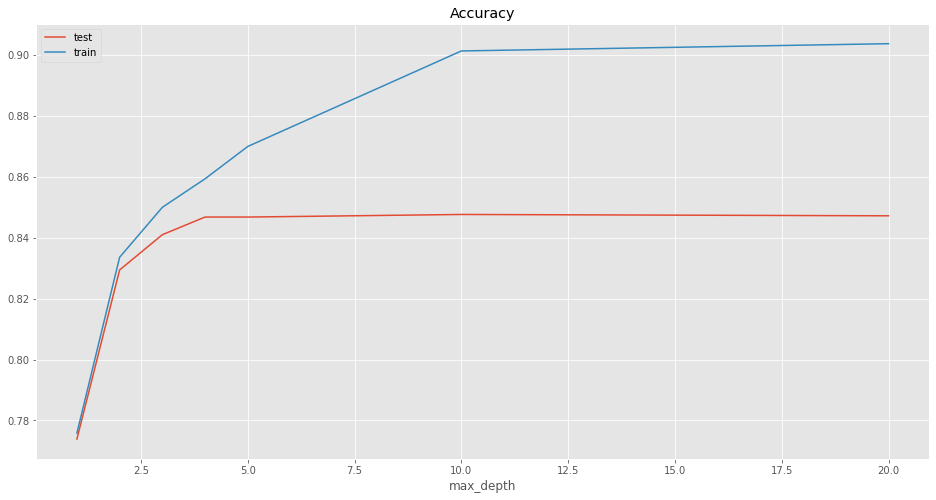

Лучший f1_score  0.8709765805449132 with 10 max_depth


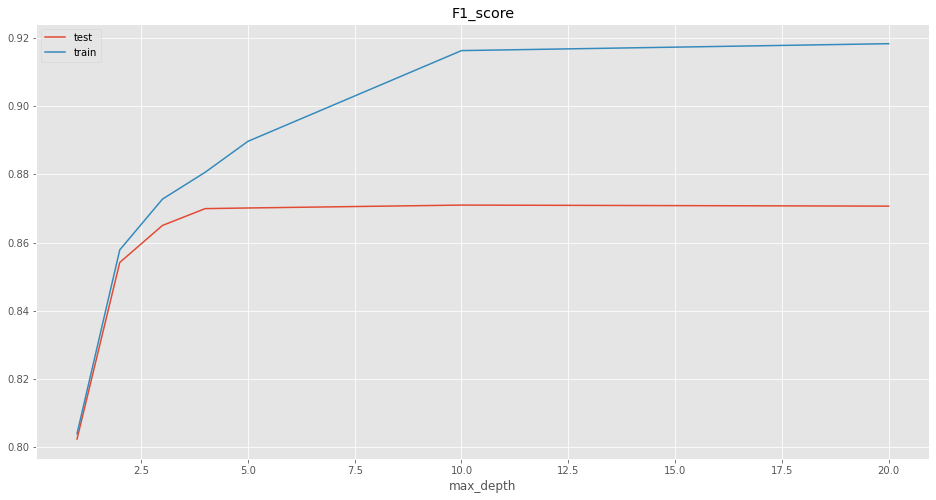

In [224]:
visualize(test_acc, train_acc, test_f1, train_f1, trees_grid, "max_depth")

In [238]:
train_acc = []
test_acc = []
train_f1 = []
test_f1 = []
trees_grid = [0.001, 0.005, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.1, 0.3, 0.5, 0.8, 1]
for ntrees in tqdm(trees_grid):
    GB = LGBMClassifier(n_estimators=150, random_state=42, num_leaves=60, learning_rate=ntrees, max_depth=10)
    temp_train_acc, temp_test_acc, temp_train_f1, temp_test_f1 = CV(GB, np.concatenate((X_train_rf, X_test_rf)), np.concatenate((y_train_rf, y_test_rf)))
    train_acc.append(temp_train_acc)
    test_acc.append(temp_test_acc)
    train_f1.append(temp_train_f1)
    test_f1.append(temp_test_f1)

Best accuracy_store is 0.8495088211892494 with 0.06 learning_rate


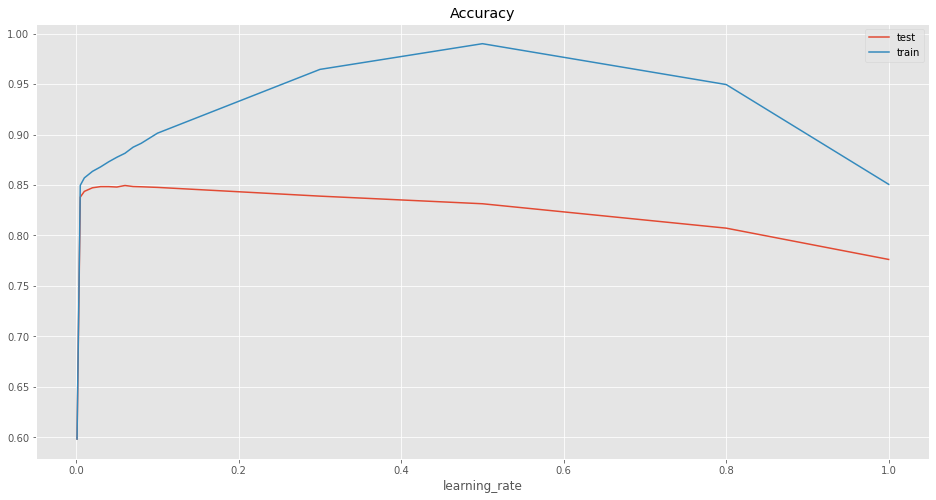

Лучший f1_score  0.8722762152961957 with 0.06 learning_rate


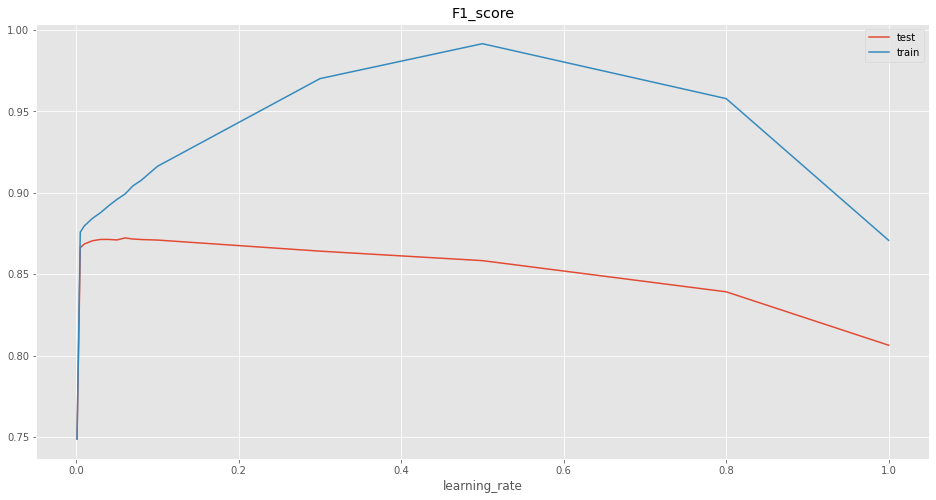

In [240]:
 visualize(test_acc, train_acc, test_f1, train_f1, trees_grid, "learning_rate")

In [ ]:
X_rf, y_rf = X2[index], y2[index]
count = np.min(((y_rf==0).sum(), (y_rf==1).sum()))
ind0 = np.random.choice((y_rf==0).sum(), size=count, replace=False)
ind1 = np.random.choice((y_rf==1).sum(), size=count, replace=False)

robust = RobustScaler()
robust.fit_transform(X2_train_not_scaling)
#print(X[y==1].shape, len(y[y==2][ind2]), np.sum(y[y==2][ind2]))
#print((X[y==2][ind2] == X[y==1][ind1][23], g((X[y==2][ind2] == X[y==1][ind1][23])))
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.999, random_state = 42, stratify=y)
X_rf, y_rf = robust.transform(np.concatenate((X_rf[y_rf==0][ind0], X_rf[y_rf==1][ind1]))), np.concatenate((y_rf[y_rf==0][ind0], y_rf[y_rf==1][ind1]))
print(X_rf, y_rf)

# Проверка точности по подклассам звезд

In [17]:
df_sub = pd.read_pickle('df_done_sub.pkl') #выборка с уже объединеными подклассами звезд 
df_sub.head()

objID         ra       dec         z      zErr   class  \
0  1237679341106758387  37.470142 -5.554778  0.785255  0.000138  GALAXY   
1  1237679341106757929  37.431501 -5.600435  1.285837  3.473993     QSO   
2  1237679341106758149  37.388988 -5.556329  0.779955  0.000054  GALAXY   
3  1237679440426172681  37.327114 -5.485252  0.714883  0.000028  GALAXY   
4  1237679341106692861  37.315868 -5.519308  0.316563  0.000031  GALAXY   

  subClass  psfMag_u  psfMag_g  psfMag_r  psfMag_i  psfMag_z  cModelMag_u  \
0      NaN  23.38412  23.00183  22.67571  21.95927  21.39581     20.01718   
1      NaN  22.52914  23.78679  23.21358  22.17294  21.80350     21.23949   
2      NaN  25.44541  23.13342  23.57675  24.34838  22.31492     20.38550   
3      NaN  25.43466  23.13782  23.31316  22.53812  22.60905     25.45580   
4      NaN  23.17536  21.34756  20.35171  20.05924  19.64511     21.14052   

   cModelMag_g  cModelMag_r  cModelMag_i  cModelMag_z  
0     21.90474     21.99600     21.05722     20.29795  
1     20.26025     22.12909     21.14929     20.66354  
2     22.09762     23.74675     24.19759     20.62257  
3     22.96513     23.37321     22.59266     22.64923  
4     20.62957     19.60872     19.07587     18.90757

In [18]:
labels = {'STAR':0, 'GALAXY':1, 'QSO':1}
df_sub.replace({'class':labels}, inplace = True)
df_sub.head()

objID         ra       dec         z      zErr  class  \
0  1237679341106758387  37.470142 -5.554778  0.785255  0.000138      1   
1  1237679341106757929  37.431501 -5.600435  1.285837  3.473993      1   
2  1237679341106758149  37.388988 -5.556329  0.779955  0.000054      1   
3  1237679440426172681  37.327114 -5.485252  0.714883  0.000028      1   
4  1237679341106692861  37.315868 -5.519308  0.316563  0.000031      1   

  subClass  psfMag_u  psfMag_g  psfMag_r  psfMag_i  psfMag_z  cModelMag_u  \
0      NaN  23.38412  23.00183  22.67571  21.95927  21.39581     20.01718   
1      NaN  22.52914  23.78679  23.21358  22.17294  21.80350     21.23949   
2      NaN  25.44541  23.13342  23.57675  24.34838  22.31492     20.38550   
3      NaN  25.43466  23.13782  23.31316  22.53812  22.60905     25.45580   
4      NaN  23.17536  21.34756  20.35171  20.05924  19.64511     21.14052   

   cModelMag_g  cModelMag_r  cModelMag_i  cModelMag_z  
0     21.90474     21.99600     21.05722     20.29795  
1     20.26025     22.12909     21.14929     20.66354  
2     22.09762     23.74675     24.19759     20.62257  
3     22.96513     23.37321     22.59266     22.64923  
4     20.62957     19.60872     19.07587     18.90757

In [19]:
df_sub[df_sub['class']==0]['subClass'].value_counts()

F     367866
M     179953
K     152959
A      95455
G      93480
WD     34472
C      14451
OB     13731
LT      7996
Name: subClass, dtype: int64

In [33]:
X_sub = df.drop(['class','subClass', 'objID', 'z', 'zErr', 'ra', 'dec', 'ob'], axis = 1).values
y_sub = df['ob'].values
sub = df['subClass']
robust = RobustScaler()
robust.fit_transform(X_train_not_scaling)
X_sub_test_not_scaling = X_sub.copy()
X_sub = robust.transform(X_sub)

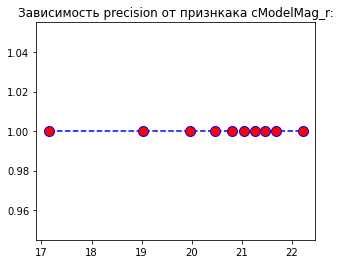

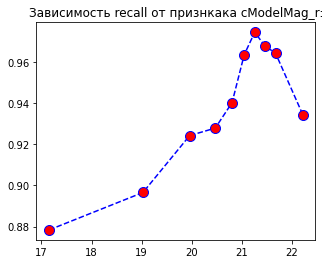

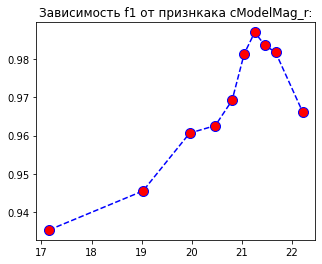

In [35]:
print_plot2(gb, X_sub[sub == 'OB'], y_sub[sub == 'OB'], X_sub_test_not_scaling[sub == 'OB'])

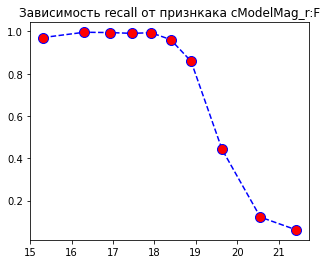

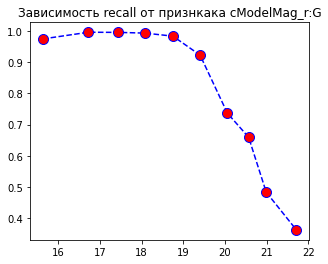

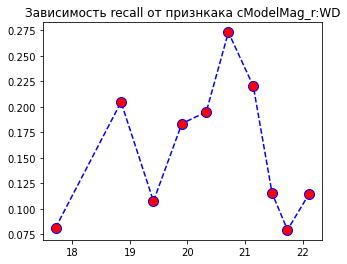

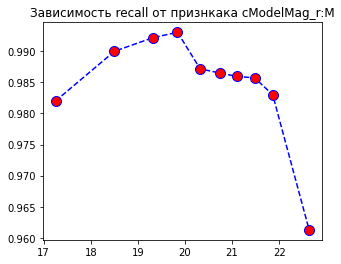

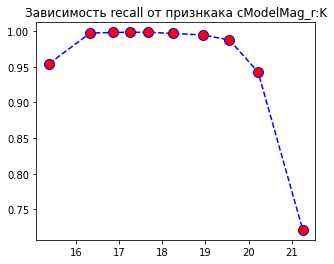

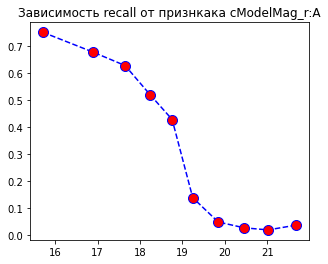

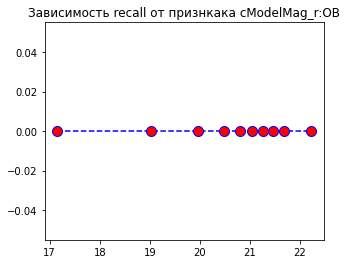

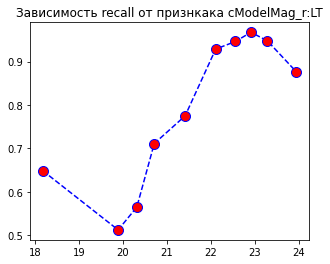

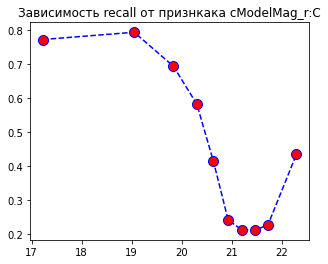

In [57]:
for i in df[df['class']==1]['subClass'].unique():
    print_plot1(gb, X_sub[sub == i], y_sub[sub == i], X_sub_test_not_scaling[sub == i], i)

In [56]:
def print_plot1(ml, X_sub, y_sub, X_sub_test_not_scaling, sub):
    
    X_test_not_scaling = X_sub_test_not_scaling[X_sub_test_not_scaling[:,7].argsort()]
    X_test = X_sub[X_sub_test_not_scaling[:,7].argsort()]
    y_test = y_sub[X_sub_test_not_scaling[:,7].argsort()]
    
    #shift = 1000
    #n = len(y_test)//shift
    n = 10
    shift = len(y_test)//n
    precision = []
    recall = []
    f1 = []
    r_mean = []
    y_pred_all = ml.predict(X_test)

    for i in range(0, n):
            h = classification_report(y_test[i*shift : (i+1) * shift], y_pred_all[i*shift : (i+1) * shift], output_dict=True, zero_division=0)
            precision.append(h['1']['precision'])
            recall.append(h['1']['recall'])
            f1.append(h['1']['f1-score'])
            r_mean.append(X_test_not_scaling[i*shift : (i+1) * shift][:,7].mean())
            
    #plt.figure(figsize = (5,4))
    #plt.title('Зависимость precision от признкака cModelMag_r:'+i)
    #plt.plot(r_mean, precision, color='blue', linestyle='dashed', marker='o', markerfacecolor='red', markersize=10)
    plt.figure(figsize = (5,4))
    plt.title('Зависимость recall от признкака cModelMag_r:'+sub)
    plt.plot(r_mean, recall, color='blue', linestyle='dashed', marker='o', markerfacecolor='red', markersize=10)
    #plt.figure(figsize = (5,4))
    #plt.title('Зависимость f1 от признкака cModelMag_r:')
    #plt.plot(r_mean, f1, color='blue', linestyle='dashed', marker='o', markerfacecolor='red', markersize=10)

In [79]:
def print_plot3(ml, X_sub, y_sub, X_sub_test_not_scaling, name):   #функция для построения общего графика для всех подклассов
    
    X_test_not_scaling = X_sub_test_not_scaling[X_sub_test_not_scaling[:,7].argsort()]
    X_test = X_sub[X_sub_test_not_scaling[:,7].argsort()]
    y_test = y_sub[X_sub_test_not_scaling[:,7].argsort()]
    
    #shift = 1000
    #n = len(y_test)//shift
    n = 10
    shift = len(y_test)//n
    precision = []
    recall = []
    f1 = []
    r_mean = []
    
    #shift1 = []
    
    y_pred_all = ml.predict(X_test)

    for i in range(0, n):
            h = classification_report(y_test[i*shift : (i+1) * shift], y_pred_all[i*shift : (i+1) * shift], output_dict=True, zero_division=0)
            #precision.append(h['0']['precision'])
            recall.append(h['1']['recall'])
            #f1.append(h['0']['f1-score'])
            r_mean.append(X_test_not_scaling[i*shift : (i+1) * shift][:,7].mean())
            #shift1.append(np.log10(len(y_test[i*shift : (i+1) * shift])))
            
    return r_mean, recall, shift

In [80]:
subclass = df[df['class']==1]['subClass'].unique()[df[df['class']==1]['subClass'].value_counts()[df[df['class']==1]['subClass'].unique()].argsort()]

['F' 'M' 'K' 'A' 'G' 'WD' 'C' 'OB']


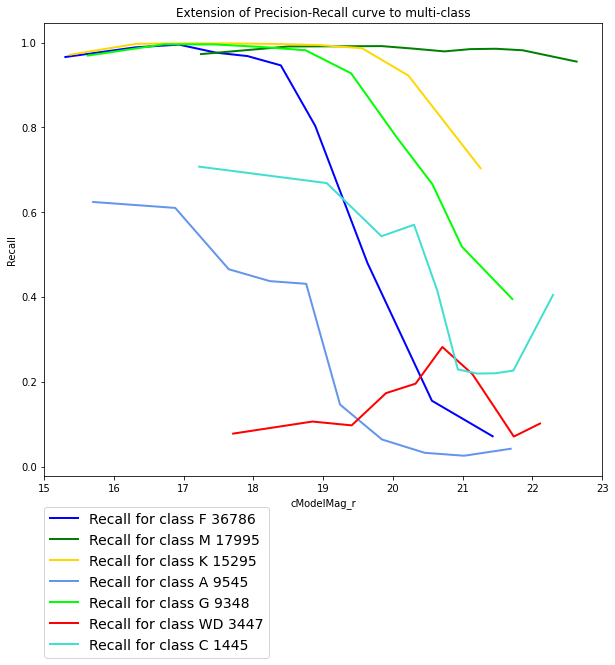

In [83]:
from itertools import cycle
# setup plot details
colors = cycle(['blue', 'g', 'gold', 'cornflowerblue', 'lime', 'r', 'turquoise', 'magenta'])
#n_classes = 9

plt.figure(figsize=(10, 10))

lines = []
labels = []

print(subclass[1:][::-1])
for i, color in zip(subclass[2:][::-1], colors):
    x, y, shift = print_plot3(rf, X_sub[sub == i], y_sub[sub == i], X_sub_test_not_scaling[sub == i], i)
    #print(x, y)
    l, = plt.plot(x, y, color=color, lw=2)
    lines.append(l)
    labels.append('Recall for class '+ i + ' ' + str(shift))

fig = plt.gcf()
fig.subplots_adjust(bottom=0.25)
plt.xlim([15, 23])
#plt.ylim([0.4, 1.05])
plt.xlabel('cModelMag_r')
plt.ylabel('Recall')
plt.title('Extension of Recall curve to multi-class')
plt.legend(lines, labels, loc=(0, -0.4), prop=dict(size=14))


plt.show()

